In [12]:
from dotenv import load_dotenv
load_dotenv()

False

In [13]:
import os
import keyring

OPENAI_API_KEY = keyring.get_password('openai', 'key_for_windows')
TAVILY_API_KEY = keyring.get_password('tavily', 'key_for_windows')
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

In [14]:
from openai import OpenAI
from pydantic import BaseModel, Field
from langchain_core.tools import tool

client = OpenAI()

# Define a schema for generating DALL-E image instead of simple strings
class GenImageSchema(BaseModel):
    prompt: str = Field(description="The prompt for image generation")
    
# Define function for generating DALL-E image
@tool(args_schema=GenImageSchema)
def generate_image(prompt: str) -> str:
    """ 
    Generate an image using DALL-E based on the given prompt.
    """
    response = client.images.generate(
        model='dall-e-3',
        prompt=prompt,
        size='1024x1024',
        quality='standard',
        n=1
    )
    return response.data[0].url

In [15]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from datetime import datetime
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model='gpt-4o-mini',
    temperature=0
)

system_prompt = f"""
Today is {datetime.now().strftime('%Y-%m-%d')}
You are a helpful AI Assistant that can use web search tool(tavily ai api) and image generation tool (DallE API).
You should always answer in same language as user's ask.
When user ask about the information that you can't answer, you should call the search tool.
When user ask about the generating image, you should call the generate_image tool.

web search tool is useful when:
- real-time info
- local specialized info
- metric related info

you should use web search tool with the guideline below:
- Extract the user query's intent and rephrase the prompt into appropriate search query
- web search tool(Tavily AI API) can deal with the sentence query.
- you don't need to limit your querying ability to generating keyword only query.

generate_image tool is useful when:
Visual exploration : when you need to visualize abstract concepts, hypothetical scenarios, or creative ideas.
Customization: when you want specific scenes, characters, or objects to be illustrated in detail.
Creative brainstorming: when generating variations of ideas, styles, or settings to inspire creative work.

Guideline for using the Image generation tool:
Extract the user query's intent:
Determine what the user wants to see or visualize. Identify the main subject, style performance, context, and specific elements they are interested in.
Pay attention to any specific adjectives, details, or emotions that the user emphasizes.
Look for clues about desired art styles, color themes, or scenarios.

Rephrase the Prompt into a Detailed Image Generation Query:
Include relevant details about the main subject, setting, perspective, style, and any additional objects or themes.
Use natural language to clearly describe what the scene should look like, emphasizing the desired atmosphere, colors, and mood.
If the user provides vague descriptions, add assumptions based on common interpretatios or clarify with a follow-up.
"""

prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(system_prompt),
    HumanMessagePromptTemplate.from_template("{input}")
])


search = TavilySearchResults(max_results=5)

tools = [search, generate_image]
llm_with_tools = llm.bind_tools(tools)

chain = prompt | llm_with_tools

In [16]:
result = chain.invoke("generate the image of a dog")
print(result)

content='' additional_kwargs={'tool_calls': [{'id': 'call_togWH51YvoarOsp6LYv28ytq', 'function': {'arguments': '{"prompt":"A realistic and detailed illustration of a happy dog sitting in a sunny park. The dog has a shiny coat, bright eyes, and a wagging tail. In the background, there are green trees, a blue sky, and a few fluffy clouds. The scene conveys a cheerful and playful atmosphere."}', 'name': 'generate_image'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 497, 'total_tokens': 569, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_818c284075', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-c2411f43-138c-4ec5-b5c7-fca49e219252-0' tool_calls=[{'name': 'generate_image', 'args': {'prom

In [17]:
print(result.additional_kwargs['tool_calls'][0]['function']['arguments'])

{"prompt":"A realistic and detailed illustration of a happy dog sitting in a sunny park. The dog has a shiny coat, bright eyes, and a wagging tail. In the background, there are green trees, a blue sky, and a few fluffy clouds. The scene conveys a cheerful and playful atmosphere."}


In [18]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]
    
def chatbot(state: State):
    return {"messages": [chain.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

# add a tool node
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# add a conditional edge
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# add an edge for returning to the chatbot after tool calling
graph_builder.add_edge("tools", "chatbot")

# add an inital point
graph_builder.add_edge(START, "chatbot")

# compile the graph
graph = graph_builder.compile()

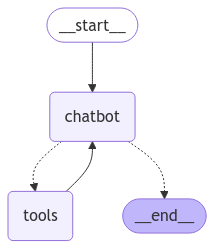

In [19]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
# the config is the **second positional argument** to stream() or invoke()!
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [("user", input("User: "))]}, config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Claude의 computer use에 대해서 조사하고, 이를 그림으로 표현해줘.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_zYk6iq26H8r1ZbVIBpsrx55j)
 Call ID: call_zYk6iq26H8r1ZbVIBpsrx55j
  Args:
    query: Claude computer use
  generate_image (call_c78MWKHwHEZpdlfs7dt4Y3z2)
 Call ID: call_c78MWKHwHEZpdlfs7dt4Y3z2
  Args:
    prompt: A creative illustration depicting a character named Claude using a computer. The scene shows Claude sitting at a desk, focused on the screen, with various tech gadgets around him. The room is modern and well-lit, with a window showing a cityscape outside. Claude is portrayed as an engaged and curious individual, with a thoughtful expression, surrounded by books and notes, symbolizing his dedication to learning and technology.
================================= Tool Message =================================
Name: generate_imag